In [2]:
from common import *
from common import MyAxes3D
import signac
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib
import numpy as np
%matplotlib inline

In [3]:
data_path = "/home/sthomas/projects/LJ_System_Size"

names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

project = signac.get_project(data_path)
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
df = pd.DataFrame(statepoints).T.join(df_index)
#df.head()

In [4]:
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate


import os
import math
import gsd
import gsd.fl
import gsd.hoomd


df_filtered = df[(df.t_Final==1e7)&
                ((df.n_particles>=1e5)|
                 (df.n_particles==5e4)|
                 (df.n_particles==8e4))]

df_sorted=df_filtered.sort_values('n_particles')
#Ns=df_sorted.n_particles.unique()
#print(Ns)
Ns=[]
mean_qs_for_Ns = []
mean_Is_for_Ns = []
mean_times_for_Ns = []
std_qs_for_Ns = []
std_Is_for_Ns = []
q_hbls=[]
USE_INDE_FRAMES=False
for N,df_grp in df_sorted.groupby('n_particles'):
    times_for_all_trials=[]
    qs_for_all_trials=[]
    Is_for_all_trials=[]

    qms_all=[] #qmax
    Is_all=[]
    Qs_all=[]
    times_all=[]
    cure_all=[]
    mean_qs=[]
    mean_Is=[]
    std_qs=[]
    std_Is=[]
    mean_qms=[]
    mean_Is_of_qm=[]
    
    for signac_id in df_grp.index:
        job = project.open_job(id=signac_id)
        #print(job)
        if 'Lx' in job.document:#checking if the job completed
            #print(job)
            if USE_INDE_FRAMES:
                mqfif,stdqfif,mifif,stdifif = get_mean_sf_from_independent_frames(job,equilibrated_percent=90)
                #print(N,mqfif)
                mean_qs.append(mqfif)
                std_qs.append(stdqfif)
                mean_Is.append(mifif)
                std_Is.append(stdifif)
            else:
                diffract_dir ='diffract_type_2'
                n_particles=job.sp.n_particles
                if job.isfile('{}/asq.txt'.format(diffract_dir)):
                    data=np.genfromtxt(job.fn('{}/asq.txt'.format(diffract_dir)))
                    #print(np.shape(data[:,0]))
                    q=data[:,0]
                    I=data[:,1]
                    mean_qs.append(q)
                    #std_qs.append(stdqfif)
                    mean_Is.append(I)
                    #std_Is.append(stdifif)
                    
                else:
                    print(job)
                    print('Final frame is not diffracted')
        else:
            print('Lx not found for',job)
    if len(mean_qs)>0:
        print('q calculated from',len(mean_qs),'trials for N=',N)
        mean_q_for_N = np.mean(mean_qs,axis=0)
        mean_qs_for_Ns.append(mean_q_for_N)
        std_q_for_N = stats.sem(mean_qs,axis=0)
        std_qs_for_Ns.append(std_q_for_N)
        mean_I_for_N = np.mean(mean_Is,axis=0)
        mean_Is_for_Ns.append(mean_I_for_N)
        std_I_for_N = stats.sem(mean_Is,axis=0)
        std_Is_for_Ns.append(std_I_for_N)
        Ns.append(N)
#print((mean_qs_for_Ns))
#print(std_Is_for_Ns)
#print(Ns)

q calculated from 3 trials for N= 50000.0
q calculated from 3 trials for N= 80000.0
q calculated from 3 trials for N= 100000.0
q calculated from 3 trials for N= 200000.0
q calculated from 3 trials for N= 400000.0
q calculated from 3 trials for N= 600000.0
q calculated from 3 trials for N= 800000.0
q calculated from 3 trials for N= 1000000.0
Lx not found for b2aea2daba3d84311a6e664fbb4ad3f1
Lx not found for d02d14b7995d6a2866ba7a2c4c9597f6
Lx not found for b0bc66fa9ae800b457ccbc67f8debeaa


[50000.0, 80000.0, 100000.0, 200000.0, 400000.0, 600000.0, 800000.0, 1000000.0]
[0.2706786474320498, 0.2148377725895124, 0.2344606689491565, 0.2234402894435762, 0.21992640103854047, 0.25127578526617805]
mean first peak 0.2357699274531689


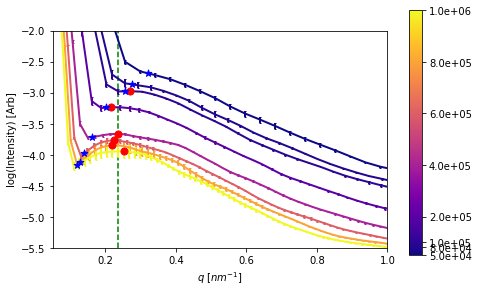

In [16]:
fig = plt.figure()
ax = fig.gca()
ax1 = fig.add_axes([ 0.95, 0.10,0.03, 0.85])

ticks=Ns

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=np.min(Ns), vmax=np.max(Ns))
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=ticks,
                                format = "%.1e",
                                spacing='uniform',
                                orientation='vertical')

for l in ax1.yaxis.get_ticklabels():
    #l.set_weight("bold")
    l.set_fontsize(10)
print(Ns)
cmap_indices = []
maxN = np.max(Ns)
minN = np.min(Ns)
for N in Ns:
    cmap_i = (N-minN)/(maxN-minN)
    cmap_indices.append(cmap_i)
#cmap = [plt.cm.plasma(i) for i in np.linspace(0, 1, len(Ns))]
cmap = [plt.cm.plasma(i) for i in cmap_indices]
ax.set_prop_cycle(color=cmap)
offsets = np.linspace(0,4,num=len(Ns))
first_peak_qs=[]
for i,N in enumerate(Ns):
    #print('N',N)
    #i=l-i_temp-1
    q=mean_qs_for_Ns[i]
    I=mean_Is_for_Ns[i]
    I_std=std_Is_for_Ns[i]
    #print('I_std',I_std)
    #print(len(I))

    offset = 0#offsets[i]
    #time=time_mean[i]
    legend='{:.1e}'.format(N)
    fn = interpolate.interp1d(q,I,kind='cubic')
    ax.errorbar(q,
                I+offset,
                I_std,
                #marker='.',
                markersize=5,
                linewidth=2,
                capsize=1,
                label=legend,
                zorder=1)
    #df_filtered= df[(df.t_Final==6e6)&
    #               (df.n_particles==N)]
    df_filt = df_filtered[df_filtered.n_particles==N]
    sids = df_filt.signac_id
    job = project.open_job(id=sids[0])
    if 'Lx' not in job.document:
        print(job,'does not contain Lx')
        continue
    first_peak_q,first_peak_i = get_highest_maxima(job.document['Lx'],q,I)
    #print(first_peak_q,first_peak_i)
    if first_peak_q is not None:
        if first_peak_q <0.8:
            first_peak_qs.append(first_peak_q)
            ax.scatter(first_peak_q, 
                   first_peak_i+offset,
                   color='r',s=50,zorder=2)
    half_box_length = job.document['Lx']/2
    q_hbl = 2*math.pi/(half_box_length*1.06)
    ax.scatter(q_hbl,
                fn(q_hbl)+offset,
                marker='*',
                s=50,
                color='b',
                zorder=2)#,s=10)

print(first_peak_qs)
mean_q=np.mean(first_peak_qs)
print('mean first peak',mean_q)
ax.axvline(x=mean_q,linestyle='--',color='g',zorder=0)#,label='$\\langle q_{max}\\rangle$')

ax.set_xlabel(r"$q$ [$nm^{-1}$]")
ax.set_ylabel("log(Intensity) [Arb]")
#ax.legend(fontsize=10)
ax.set_xlim(0.05,1.0)
ax.set_ylim(-5.5,-2.0)
savefig(plt,
       'lj_model_min_sys_size',
       'lj_finite_size_effect.pdf')
plt.show()